In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.schema import Document  # Optional: For using Document objects
from langchain_core.runnables import chain
from langchain.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

import sqlite3
import pandas as pd
from typing import List, Dict

from typing_extensions import TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
def create_retriever(docs_list,embeddings):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )

    # (Optional) Convert dictionaries to Document objects for better compatibility
    documents = [Document(page_content=doc['page_content'], metadata=doc['metadata']) for doc in docs_list]

    # Split the documents into smaller chunks
    split_docs = text_splitter.split_documents(documents)


    # Add to vectorDB
    vectorstore = Chroma.from_documents(
        documents=split_docs,
        collection_name="sql-rag-test2",
        embedding=embeddings,
    )
    retriever = vectorstore.as_retriever(search_kwargs={'k': 3})
    return retriever

def call_db(local_db_path=None,query=None,info=None):
    assert local_db_path is not None
    assert query is not None
    assert info is not None
    # print("local_db_path: ",local_db_path)
    local_conn = sqlite3.connect(local_db_path)
    with sqlite3.connect(local_db_path) as local_conn:
        cursor = local_conn.cursor()
        cursor.execute(query, (info,))
        rows = cursor.fetchall()
        column_names = [column[0] for column in cursor.description]
        results = [dict(zip(column_names, row)) for row in rows]
    return results

In [3]:
class FormatAns(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    user_input: str = Field(description='The user specified input for the SQL query.')
    sql_query: str = Field(
        description="Syntactically valid SQL query."
    )

class Plan(BaseModel):
    """Plan to follow in future"""

    plan: str = Field(
        description="steps to follow, should be in sorted order"
    )

# Data model - how to track information over states
class Grade(BaseModel):
    """Binary score for relevance check to generate sql or do rag."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


In [4]:
# original
template = """
You are an assistant for generating sql queries. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Only answer with a sql query.
**When the sql is generated, replace any user defined values with a question mark.**
===
Example:
Question: What airport am I flying out of? my passenger id is \"3442 587242.\"
Context:[Document(page_content='How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.\n        The database is named query_results.')]
user_input: 3442 587242
sql_query: SELECT departure_airport FROM query_results WHERE passenger_id = ?
===
Question: {question} 
Context: {context} 
"""

chat_prompt = ChatPromptTemplate.from_template(template)

process_template = """
You are an assistant that answers a user's question based on json. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Answer in a personal, conversational tone.
Question: {question} 
Context: {context} 
"""

process_prompt = ChatPromptTemplate.from_template(process_template)

# Add prompt to creates plan on how to generate sql query
plan_template = """
You are a helpful assistant that generates two precise plan on how to implement a sql query.
Make sure to pay attention to the user input provided in the question.
===
Question: What airport am I flying out of? my passenger id is \"3442 587242.\"
Context:[Document(page_content='How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.\n        The database is named query_results.')]
Plan: This SQL command retrieves all columns (SELECT *) from a table named query_results where the passenger_id column matches the value provided by the ? placeholder. The ? is a parameter marker, indicating a value will be passed in later to complete the query.
===
Question: {question} 
Context: {context} 
"""


plan_prompt = ChatPromptTemplate.from_template(plan_template)

# Add prompt to creates plan on executing plan


exec_template = """
You are an assistant for generating sql queries. Use the following pieces of a plan to answer the question. 
If you don't know the answer, just say that you don't know. Only answer with a sql query. When the sql is generated, replace the user defined values with a question mark.
*Do not have user input be in brackets or quotations at the final answer.
*Make sure to pay attention to the user input value, [ticket_no] is not correct.
Question: {question} 
Plan: {plan} 
"""
execute_prompt = ChatPromptTemplate.from_template(exec_template)

process_template2 = """
You are an assistant that answers a user's question based on json. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Do not answer based on the plan. Answer in a personal, conversational tone.
Question: {question} 
Plan: {plan}
Context: {context} 
"""

process_prompt2 = ChatPromptTemplate.from_template(process_template2)

# Add prompt to creates plan on how to generate sql query
grade_template = """
Give a binary score 'yes' or 'no' to indicate whether the context and the question needs sql query generation.
Make sure to pay attention to the user input provided in the question.
===
Examples:
Question: How can I reschedule my flight?
Context: How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to you.
binary_score=no

Question: Can you tell me about my flight? my passenger id is \"3442 587242.\"
Context: [Document( page_content='How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.\n        The database is named query_results.'), Document( page_content='How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to you.'), Document( page_content='How to submit expense report: go to concur through home.hpe.com, and follow the necessary forms.')] 
binary_score=yes
===
Question: {question} 
Context: {context} 
"""


grade_prompt = ChatPromptTemplate.from_template(grade_template)

rag_template = """
You are a helpful assistant that answers question based on retrieved context.
Question: {question} 
Context: {context} 
"""


rag_prompt = ChatPromptTemplate.from_template(rag_template)

# Initalize Vector DB and Models

In [ ]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

In [6]:
# Create RAG DB
docs_list = [
        {'metadata':{},'page_content':"""
        How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.
        The database is named query_results. 
        """},
        {'metadata':{},'page_content':'How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to you.'},
        {'metadata':{},'page_content':'How to submit expense report: go to concur through home.hpe.com, and follow the necessary forms.'}
    ]
embeddings = NVIDIAEmbeddings(base_url='https://integrate.api.nvidia.com/v1',
                                model="nvidia/llama-3.2-nv-embedqa-1b-v1", 
                                api_key=os.environ["NVIDIA_API_KEY"],
                                truncate="NONE")

retriever = create_retriever(docs_list,embeddings)
local_db_path = 'tickets_joined.db'

# Create models

llm = ChatNVIDIA(base_url="http://10.182.1.167:8080/v1",
                  model="meta/llama-3.1-70b-instruct", 
                   api_key="\'\'",
                   verbose=True)
formatted_llm = ChatNVIDIA(base_url="http://10.182.1.167:8080/v1",
                  model="meta/llama-3.1-70b-instruct", 
                   api_key="\'\'",
                   verbose=True).with_structured_output(FormatAns)
plan_llm = ChatNVIDIA(base_url="http://10.182.1.167:8080/v1",
                  model="meta/llama-3.1-70b-instruct", 
                   api_key="\'\'",
                   verbose=True).with_structured_output(Plan)

# LangGraph implementation

In [7]:
# Utilites and code needed to run agent with LangGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        structured_sql_query: Generated SQL query with user defined value
        sql_results: data returned from SQL query (in list of json dicts)
        plan: LLM generated plan how to generate the SQL query
        documents: list of documents
        times_transformed: number of times the question has been re-written
        sql_gen_check: string of 'yes' or 'no' to determine if we should route to gen sql, or rag
    """

    question: str
    generation: str
    structured_sql_query: FormatAns
    sql_results: List[Dict]
    plan: Plan
    documents: List[str]
    sql_gen_check: Grade


def retrieve(state):
    print("---RETRIEVE---")
    print("state: ",state)

    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question,'plan':None}


def gen_sql_query(state):
    print("---GENERATE_SQL_QUERY---")
    formatted = chat_prompt.invoke({"context": state['documents'], 
                                    "question": state['question']})
    # print(formatted.to_string())
    # generate answer
    query_result = formatted_llm.invoke(formatted)
    # print("query_result.user_input: ",query_result.user_input)
    # print("query_result.user_input: ",query_result.sql_query)
    return {"documents": state['documents'], 
            "question":  state['question'],
            'plan': state['plan'],
            "structured_sql_query": query_result}
def execute_sql_query(state):
    print("---EXEC_SQL_QUERY---")
    print(state)
    query_result = state['structured_sql_query']
    r = None
    try:
        r = call_db(local_db_path=local_db_path,
                    query=query_result.sql_query,
                    info=query_result.user_input)
        print("r: ",r)
        return {"documents": state['documents'], 
            "question":  state['question'],
            "structured_sql_query": state['structured_sql_query'],
            'plan': state['plan'],
            "sql_results": r}
    except Exception as e:
        print(e)
        return {"documents": state['documents'], 
            "question":  state['question'],
            "structured_sql_query": state['structured_sql_query'],
            'plan': state['plan'],
            "sql_results": r}

    
def answer(state):
    # By default, the new value returned by each node will override the prior state value.
    print("---ANSWER---")
    print("state: ",state)

    final_format = process_prompt.invoke({"context": state["sql_results"], "question": state["question"]})
    print(final_format.to_string())
    # structured_answer = parser.parse(answer)
    answer = llm.invoke(final_format)
    return {"documents": state["documents"], 
            "question":  state["question"], 
            "structured_sql_query": state['structured_sql_query'],
            "sql_results": state['sql_results'],
            'plan': state['plan'],
            "generation":answer}
def plan(state):
    docs = state['documents']
    question = state['question']
    plan = plan_prompt.invoke({"context": docs, "question": question})
    ans = plan_llm.invoke(plan)
    return {'question':state['question'],
            'documents':state['documents'],
            'plan':ans}

#update function
def gen_sql_query2(state):
    print("---GENERATE_SQL_QUERY---")
    plan = state['plan']
    docs = state['documents']
    question = state['question']
    exec = execute_prompt.invoke({"plan": plan.plan, "question": question,'context':docs})
    print(exec.to_string())
    query_result = llm.with_structured_output(FormatAns).invoke(exec)
    print(type(query_result))
    # print(formatted.to_string())
    # generate answer
    # query_result = formatted_llm.invoke(ans2)
    print("query_result.user_input: ",query_result.user_input)
    print("query_result.user_input: ",query_result.sql_query)
    return {"documents": state['documents'], 
            "question":  state['question'],
            'plan': state['plan'],
            "structured_sql_query": query_result}
def check(state):
    '''
    '''
    docs = state['documents']
    print("docs: ",docs)
    question = state['question']
    print("question: ",question)
    grade = grade_prompt.invoke({"context": docs, "question": question})
    ans = llm.with_structured_output(Grade).invoke(grade)
    print("ans: ",ans)
    return {"documents": state['documents'], "question": state['question'],'sql_gen_check':ans,'plan':None}
def decide(state):
    '''
    '''

    ans = state['sql_gen_check'].binary_score
    if ans == 'yes':
        return 'yes'
    elif ans == 'no':
        return 'no'

def rag_answer(state):
    # By default, the new value returned by each node will override the prior state value.
    print("---ANSWER---")
    print("state: ",state)

    final_format = process_prompt.invoke({"context": state['documents'], "question": state["question"]})
    print(final_format.to_string())
    # structured_answer = parser.parse(answer)
    answer = llm.invoke(final_format)
    return {"documents": state["documents"], 
            "question":  state["question"], 
            'plan': state['plan'],
            "generation":answer}

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder3 = StateGraph(GraphState)
builder3.add_node("retrieve", retrieve)
builder3.add_node("check",check)
builder3.add_node("generate_sql_query",gen_sql_query2)
builder3.add_node("execute_sql_query",execute_sql_query)
builder3.add_node("planning",plan)
builder3.add_node("answer", answer)
builder3.add_node("rag_answer", rag_answer)
# Build Edges
builder3.add_edge(START, "retrieve")
builder3.add_edge('retrieve','check')
builder3.add_conditional_edges('check',
                               decide,
                               {
                                   'yes':'planning',
                                   'no': 'rag_answer'},
                            )
# builder3.add_edge("retrieve", "planning")
builder3.add_edge("planning",'generate_sql_query')
builder3.add_edge("generate_sql_query","execute_sql_query")
builder3.add_edge("execute_sql_query","answer")
builder3.add_edge("answer", END)
# Compile
app3 = builder3.compile()

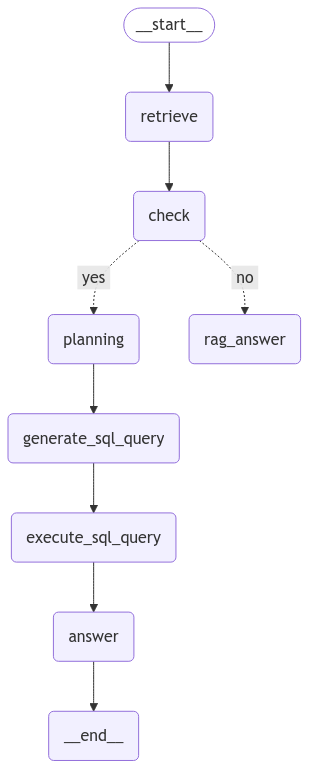

In [10]:
# Compile the graph
# app = builder3.compile()
from IPython.display import Image, display

display(Image(app3.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Run graph
inputs = {"question": "Can you tell me about my flight's departure time? my ticket_no is \"7240005432906569\"."}
for output in app3.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"].content)

---RETRIEVE---
state:  {'question': 'Can you tell me about my flight\'s departure time? my ticket_no is "7240005432906569".'}
Node 'retrieve':
docs:  [Document(metadata={}, page_content='How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.\n        The database is named query_results.'), Document(metadata={}, page_content='How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to you.'), Document(metadata={}, page_content='How to submit expense report: go to concur through home.hpe.com, and follow the necessary forms.')]
question:  Can you tell me about my flight's departure time? my ticket_no is "7240005432906569".


/var/folders/09/z9_cf8x15h99zpr_pwnx29qc0000gn/T/ipykernel_23031/1649308050.py:33: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


ans:  binary_score='yes'
Node 'check':
Node 'planning':
---GENERATE_SQL_QUERY---
Human: 
You are an assistant for generating sql queries. Use the following pieces of a plan to answer the question. 
If you don't know the answer, just say that you don't know. Only answer with a sql query. When the sql is generated, replace the user defined values with a question mark.
*Do not have user input be in brackets or quotations at the final answer.
*Make sure to pay attention to the user input value, [ticket_no] is not correct.
Question: Can you tell me about my flight's departure time? my ticket_no is "7240005432906569". 
Plan: SELECT scheduled_departure FROM query_results WHERE ticket_no = "7240005432906569" 

<class '__main__.FormatAns'>
query_result.user_input:  7240005432906569
query_result.user_input:  SELECT scheduled_departure FROM query_results WHERE ticket_no = ?
Node 'generate_sql_query':
---EXEC_SQL_QUERY---
{'question': 'Can you tell me about my flight\'s departure time? my ticket_n

In [12]:
# Run graph
inputs = {"question": "How can I reschedule my flight?"}
for output in app3.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"].content)

---RETRIEVE---
state:  {'question': 'How can I reschedule my flight?'}
Node 'retrieve':
docs:  [Document(metadata={}, page_content='How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to you.'), Document(metadata={}, page_content='How to answer questions with What. Database has 11 rows: seat_no, fare_conditions, scheduled_arrival, scheduled_departure, ticket_no, book_ref, passenger_id, flight_id, flight_no, departure_airport, arrival_airport.\n        The database is named query_results.'), Document(metadata={}, page_content='How to submit expense report: go to concur through home.hpe.com, and follow the necessary forms.')]
question:  How can I reschedule my flight?
ans:  binary_score='no'
Node 'check':
---ANSWER---
state:  {'question': 'How can I reschedule my flight?', 'plan': None, 'documents': [Document(metadata={}, page_content='How to reschedule a flight: need to email returns@hpe.com, submit request, and someone will get back to y